### Paquetes

In [1]:
import os
import datetime
import hydroeval
import hidrologia

In [2]:
import pandas as pd
from wmf import wmf
import numpy as np 
import glob 
import pylab as pl
import json
import MySQLdb
import csv
import matplotlib
import matplotlib.font_manager
from datetime import timedelta
import datetime as dt
import pickle
import matplotlib.dates as mdates
import netCDF4
import textwrap


import matplotlib 
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager

font_dirs = ['/home/socastillogi/jupyter/fuentes/AvenirLTStd-Book']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

matplotlib.rcParams['font.family'] = 'Avenir LT Std'
matplotlib.rcParams['font.size']=13
import pylab as pl 
#COLOR EDGES
pl.rc('axes',labelcolor='#4f4f4f')
pl.rc('axes',linewidth=1.5)
pl.rc('axes',edgecolor='#bdb9b6')
pl.rc('text',color= '#4f4f4f')

No se logra importar basemap, por lo tanto no funciona Plot_basin


<ipython-input-2-1838c21a63a0>:26: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [4]:
%matplotlib inline

### Probar fcn radar

#### Argumentos

In [4]:
#SETLED AS MODEL USES.
# meanrain_ALL=False,save_bin=True,
#  path_res=ruta_rain,
#  umbral=0.005,verbose=verbose,
#  complete_naninaccum = complete_naninaccum

In [6]:
start= '2021-01-06 15:40'
end= '2021-01-06 21:00'
Dt= 300.
cuenca= '../files_temp/E260_90m_py3_v111.nc' ###CAMBIAR RUTA
codigos= [260]
accum=False
path_tif=None
all_radextent=False
mask=None
meanrain_ALL=False
path_masks_csv=None
complete_naninaccum=True
save_bin=True
save_class = False
path_res= '../files_temp/binp2modelo_prueba' ###CAMBIAR RUTA
umbral=0.005
rutaNC='/var/radar/operacional/' ###CAMBIAR RUTA
verbose=True

#### Función

In [7]:
# def get_radar_rain(start,end,Dt,cuenca,codigos,accum=False,path_tif=None,all_radextent=False,
#                     mask=None,meanrain_ALL=True,path_masks_csv=None,complete_naninaccum=False,save_bin=False,
#                    save_class = False,path_res=None,umbral=0.005,
#                    rutaNC='/media/nicolas/Home/nicolas/101_RadarClass/',verbose=True):

start,end = pd.to_datetime(start),pd.to_datetime(end)
#hora UTC
startUTC,endUTC = start + pd.Timedelta('5 hours'), end + pd.Timedelta('5 hours')
fechaI,fechaF,hora_1,hora_2 = startUTC.strftime('%Y-%m-%d'), endUTC.strftime('%Y-%m-%d'),startUTC.strftime('%H:%M'),endUTC.strftime('%H:%M')

#Obtiene las fechas por dias para listar archivos por dia
datesDias = pd.date_range(fechaI, fechaF,freq='D')

a = pd.Series(np.zeros(len(datesDias)),index=datesDias)
a = a.resample('A').sum()
Anos = [i.strftime('%Y') for i in a.index.to_pydatetime()]

datesDias = [d.strftime('%Y%m%d') for d in datesDias.to_pydatetime()]

#lista los .nc existentes de ese dia: rutas y fechas del nombre del archivo
ListDatesinNC = []
ListRutas = []
for d in datesDias:
    try:
        L = glob.glob(rutaNC + d + '*.nc')
        ListRutas.extend(L)
        ListDatesinNC.extend([i.split('/')[-1].split('_')[0] for i in L])
    except:
        print ('Sin archivos para la fecha %s'%d)

# Organiza las listas de rutas y la de las fechas a las que corresponde cada ruta.
ListRutas.sort()
ListDatesinNC.sort()#con estas fechas se asignaran los barridos a cada timestep.

#index con las fechas especificas de los .nc existentes de radar
datesinNC = [dt.datetime.strptime(d,'%Y%m%d%H%M') for d in ListDatesinNC]
datesinNC = pd.to_datetime(datesinNC)

#Obtiene el index con la resolucion deseada, en que se quiere buscar datos existentes de radar, 
textdt = '%d' % Dt
#Agrega hora a la fecha inicial
if hora_1 != None:
        inicio = fechaI+' '+hora_1
else:
        inicio = fechaI
#agrega hora a la fecha final
if hora_2 != None:
        final = fechaF+' '+hora_2
else:
        final = fechaF
datesDt = pd.date_range(inicio,final,freq = textdt+'s')

#Obtiene las posiciones de acuerdo al dt para cada fecha, si no hay barrido en ese paso de tiempo se acumula 
#elbarrido inmediatamente anterior.
#Saca una lista con las pos de los barridos por cada timestep, y las pega en PosDates
#Si el limite de completar faltantes con barrido anterior es de 10 min, solo se completa si dt=300s
#limite de autocompletar : 10m es decir, solo repito un barrido.
PosDates = []
pos1 = []
pos_completed = []
lim_completed = 3 #ultimos 3 barridos - 15min
for ind,d1,d2 in zip(np.arange(datesDt[:-1].size),datesDt[:-1],datesDt[1:]):
        pos2 = np.where((datesinNC<d2) & (datesinNC>=d1))[0].tolist()

        # si no hay barridos en el dt de inicio sellena con zero - lista vacia
        #y no esta en los primero 3 pasos : 15min.
        # si se puede completar 
        # y si en el los lim_completed pasos atras no hubo más de lim_completed-1 pos con pos_completed=2, lim_completed-1 para que deje correr sólo hasta el lim_completed.
        #asi solo se pueded completar y pos_completed=2 una sola vez.
        if len(pos2) == 0 and ind not in np.arange(lim_completed) and complete_naninaccum == True and Dt == 300. and np.where(np.array(pos_completed[ind-lim_completed:])==2)[0].size <= lim_completed-1 : #+1 porque coge los ultimos n-1 posiciones.
                pos2 = pos1
                pos_completed.append(2)
        elif len(pos2) == 0:
                pos2=[]
                pos_completed.append(0)
        else:
            pos_completed.append(1)
        #si se quiere completar y hay barridos en este dt, guarda esta pos para si es necesario completar las pos de dt en el sgte paso 
        if complete_naninaccum == True and len(pos2) != 0 and Dt == 300. and np.where(np.array(pos_completed[ind-lim_completed:])==2)[0].size <= lim_completed-1 : 
            pos1 = pos2
        else:
            pos1 = []   

        PosDates.append(pos2)

# paso a hora local
datesDt = datesDt - dt.timedelta(hours=5)
datesDt = datesDt.to_pydatetime()
#Index de salida en hora local
rng= pd.date_range(start.strftime('%Y-%m-%d %H:%M'),end.strftime('%Y-%m-%d %H:%M'), freq=  textdt+'s')
df = pd.DataFrame(index = rng,columns=codigos)

#mascara con shp a parte de wmf
if mask is not None:
    #se abre un barrido para sacar la mascara
    g = netCDF4.Dataset(ListRutas[PosDates[0][0]])
    field = g.variables['Rain'][:].T/(((len(pos)*3600)/Dt)*1000.0)#g['Rain'][:]#
    RadProp = [g.ncols, g.nrows, g.xll, g.yll, g.dx, g.dx]
    g.close()
    longs=np.array([RadProp[2]+0.5*RadProp[4]+i*RadProp[4] for i in range(RadProp[0])])
    lats=np.array([RadProp[3]+0.5*RadProp[5]+i*RadProp[5] for i in range(RadProp[1])])
    x,y =  np.meshgrid(longs,lats)
    #mask as a shp
    if type(mask) == str:
        #boundaries
        shp = gpd.read_file(mask)
        poly = shp.geometry.unary_union

        shp_mask = np.zeros([len(lats),len(longs)])
        for i in range(len(lats)):
            for j in range(len(longs)):
                 if (poly.contains(Point(longs[j],lats[i])))==True:
                    shp_mask[i,j] = 1# Rain_mask es la mascara

        l = x[shp_mask==1].min()
        r = x[shp_mask==1].max()
        d = y[shp_mask==1].min()
        a = y[shp_mask==1].max()
    #mask as a list with coordinates whithin the radar extent
    elif type(mask) == list:
        l = mask[0] ; r = mask[1] ; d = mask[2] ; a = mask[3] 
        x,y = x.T,y.T #aun tengo dudas con el recorte, si en nc queda en la misma pos que los lats,longs.

    #boundaries position
    x_wh,y_wh = np.where((x>l)&(x<r)&(y>d)&(y<a))
    #se redefine sfield con size que corresponde
    field = field[np.unique(x_wh)[0]:np.unique(x_wh)[-1],np.unique(y_wh)[0]:np.unique(y_wh)[-1]]

    if save_bin and len(codigos)==1 and path_res is not None:
        #open nc file
        f = netCDF4.Dataset(path_res,'w', format='NETCDF4') #'w' stands for write

        tempgrp = f.createGroup('rad_data') # as folder for saving files
        lon = longs[np.unique(x_wh)[0]:np.unique(x_wh)[-1]]
        lat = lats[np.unique(y_wh)[0]:np.unique(y_wh)[-1]]
        #set name and leght of dimensions
        tempgrp.createDimension('lon', len(lon))
        tempgrp.createDimension('lat', len(lat))
        tempgrp.createDimension('time', None)
        #building variables
        longitude = tempgrp.createVariable('longitude', 'f4', 'lon')
        latitude = tempgrp.createVariable('latitude', 'f4', 'lat')  
        rain = tempgrp.createVariable('rain', 'f4', (('time', 'lat', 'lon')))
        time = tempgrp.createVariable('time', 'i4', 'time')
        #adding globalattributes
        f.description = "Radar rainfall dataset containing one group"
        f.history = "Created " + dt.datetime.now().strftime("%d/%m/%y")
        #Add local attributes to variable instances
        longitude.units = 'degrees east - wgs4'
        latitude.units = 'degrees north - wgs4'
        time.units = 'minutes since 2020-01-01 00:00'
        rain.units = 'mm/h'
        #passing data into variables
        # use proper indexing when passing values into the variables - just like you would a numpy array.
        longitude[:] = lon #The "[:]" at the end of the variable instance is necessary
        latitude[:] = lat

else:
    # acumular dentro de la cuenca.
    cu = wmf.SimuBasin(rute= cuenca)
    if save_class:
        cuConv = wmf.SimuBasin(rute= cuenca)
        cuStra = wmf.SimuBasin(rute= cuenca)

#accumulated in basin
if accum:
    if mask is not None:
        rvec_accum = np.zeros(field.shape)
        dfaccum = pd.DataFrame(index = rng) #este producto no da con mask.
    else:
        rvec_accum = np.zeros(cu.ncells)
#             rvec = np.zeros(cu.ncells)
        dfaccum = pd.DataFrame(np.zeros((cu.ncells,rng.size)).T,index = rng)
else:
    pass

#all extent
if all_radextent:
    radmatrix = np.zeros((1728, 1728))


#ITERA SOBRE LOS BARRIDOS DEL PERIODO Y SE SACAN PRODUCTOS
# print ListRutas
for ind,dates,pos in zip(np.arange(len(datesDt[1:])),datesDt[1:],PosDates):
        #escoge como definir el size de rvec
        if mask is not None:
            rvec = np.zeros(shape = field.shape)
        else: 
            rvec = np.zeros(cu.ncells)
            if save_class:
                rConv = np.zeros(cu.ncells, dtype = int)   
                rStra = np.zeros(cu.ncells, dtype = int)   
        try:
                #se lee y agrega lluvia de los nc en el intervalo.
                for c,p in enumerate(pos):
                        #lista archivo leido
                        if verbose:
                            print (ListRutas[p])
                        #Lee la imagen de radar para esa fecha
                        g = netCDF4.Dataset(ListRutas[p])
                        rainfield = g.variables['Rain'][:].T/(((len(pos)*3600)/Dt)*1000.0)
                        RadProp = [g.ncols, g.nrows, g.xll, g.yll, g.dx, g.dx]
                        #if all extent
                        if all_radextent:
                            radmatrix += rainfield

                        #if mask
                        if mask is not None and type(mask) == str:
                            rvec += (rainfield*shp_mask)[np.unique(x_wh)[0]:np.unique(x_wh)[-1],np.unique(y_wh)[0]:np.unique(y_wh)[-1]]
                        elif mask is not None and type(mask) == list:
                            rvec += rainfield[np.unique(x_wh)[0]:np.unique(x_wh)[-1],np.unique(y_wh)[0]:np.unique(y_wh)[-1]]
                        # on WMF.
                        else:
                            #Agrega la lluvia en el intervalo 
                            rvec += cu.Transform_Map2Basin(rainfield,RadProp)
                            if save_class:
                                ConvStra = cu.Transform_Map2Basin(g.variables['Conv_Strat'][:].T, RadProp)
                                # 1-stra, 2-conv
                                rConv = np.copy(ConvStra) 
                                rConv[rConv == 1] = 0; rConv[rConv == 2] = 1
                                rStra = np.copy(ConvStra)
                                rStra[rStra == 2] = 0 
                                rvec[(rConv == 0) & (rStra == 0)] = 0
                                Conv[rvec == 0] = 0
                                Stra[rvec == 0] = 0
                        #Cierra el netCDF
                        g.close()
                #muletilla
                path = 'bla'
        except:
                print ('error - no field found ')
                path = ''
                if accum:
                    if mask is not None:
                        rvec += np.zeros(shape = field.shape)
                        rvec = np.zeros(shape = field.shape)
                    else:
                        rvec_accum += np.zeros(cu.ncells)
                        rvec = np.zeros(cu.ncells)
                else:
                    if mask is not None:
                        rvec = np.zeros(shape = field.shape)
                    else:
                        rvec = np.zeros(cu.ncells)
                        if save_class:
                            rConv = np.zeros(cu.ncells)
                            rStra = np.zeros(cu.ncells)
                if all_radextent:
                    radmatrix += np.zeros((1728, 1728))
        #acumula dentro del for que recorre las fechas
        if accum:
            rvec_accum += rvec
            if mask is None: #esto para mask no sirve
                dfaccum.loc[dates.strftime('%Y-%m-%d %H:%M:%S')]= rvec
        else:
            pass

        # si se quiere sacar promedios de lluvia de radar en varias cuencas definidas en 'codigos'
        #subbasins defined for WMF
        if meanrain_ALL and mask is None:
            mean = []
            df_posmasks = pd.DataFrame.from_csv(path_masks_csv)
            for codigo in codigos:
                    if path == '': # si no hay nc en ese paso de tiempo.
                        mean.append(np.nan)
                    else:
                         mean.append(np.sum(rvec*df_posmasks['%s'%codigo])/float(df_posmasks['%s'%codigo][df_posmasks['%s'%codigo]==1].size))
            # se actualiza la media de todas las mascaras en el df.
            df.loc[dates.strftime('%Y-%m-%d %H:%M:%S')]=mean             
        else:
            pass

        #guarda binario y df, si guardar binaria paso a paso no me interesa rvecaccum
        if mask is None and save_bin == True and len(codigos)==1 and path_res is not None:
            mean = []
            #guarda en binario 
            dentro = cu.rain_radar2basin_from_array(vec = rvec,
                ruta_out = path_res,
                fecha = dates,
                dt = Dt,
                umbral = umbral)

            #si guarda nc de ese timestep guarda clasificados
            if dentro == 0: 
                hagalo = True
            else:
                hagalo = False
            #mira si guarda o no los clasificados
            if save_class:
                #Escribe el binario convectivo
                aa = cuConv.rain_radar2basin_from_array(vec = rConv,
                    ruta_out = path_res+'_conv',
                    fecha = dates,
                    dt = Dt,
                    doit = hagalo)
                #Escribe el binario estratiforme
                aa = cuStra.rain_radar2basin_from_array(vec = rStra,
                    ruta_out = path_res+'_stra',
                    fecha = dates,
                    dt = Dt,
                    doit = hagalo)

            #guarda en df meanrainfall.
            try:
                mean.append(rvec.mean())
            except:
                mean.append(np.nan)
            df.loc[dates.strftime('%Y-%m-%d %H:%M:%S')]=mean

        elif mask is None and save_bin == True and len(codigos)==1 and path_res is None: #si es una cuenca pero no se quiere guardar binarios.
            mean = []
            #guarda en df meanrainfall.
            try:
                mean.append(rvec.mean())
            except:
                mean.append(np.nan)
            df.loc[dates.strftime('%Y-%m-%d %H:%M:%S')]=mean

        #guardar .nc con info de recorte de radar: mask.
        if mask is not None and save_bin and len(codigos)==1 and path_res is not None:
            mean = []
            #https://pyhogs.github.io/intro_netcdf4.html
            rain[ind,:,:] = rvec.T
            time[ind] = int((dates - pd.to_datetime('2010-01-01 00:00')).total_seconds()/60) #min desde 2010
            if ind == np.arange(len(datesDt[1:]))[-1]:
                f.close()
                print ('.nc saved')
            #guarda en df meanrainfall.
            if path == '': # si no hay nc en ese paso de tiempo.
                mean.append(np.nan)
            else:
                mean.append(np.sum(rvec)/float(shp_mask[shp_mask==1].size))
            #save
            df.loc[dates.strftime('%Y-%m-%d %H:%M:%S')]=mean

if mask is None and save_bin == True and len(codigos)==1 and path_res is not None:
    #Cierrra el binario y escribe encabezado
    cu.rain_radar2basin_from_array(status = 'close',ruta_out = path_res)
    print ('.bin & .hdr saved')
    if save_class:
        cuConv.rain_radar2basin_from_array(status = 'close',ruta_out = path_res+'_conv')
        cuStra.rain_radar2basin_from_array(status = 'close',ruta_out = path_res+'_stra')
        print ('.bin & .hdr escenarios saved')
else:
    print ('.bin & .hdr NOT saved')
    pass

# #elige los retornos.
# if accum == True and path_tif is not None:
#     cu.Transform_Basin2Map(rvec_accum,path_tif)
#     return df,rvec_accum,dfaccum
# elif accum == True and mask is not None:
#     return df,rvec_accum
# elif accum == True and mask is None:
#     return df,rvec_accum,dfaccum
# elif all_radextent:
#     return df,radmatrix
# else:
#     return df     

/var/radar/operacional/202101062041_010_120.nc
/var/radar/operacional/202101062046_010_120.nc
/var/radar/operacional/202101062051_010_120.nc
/var/radar/operacional/202101062056_010_120.nc
/var/radar/operacional/202101062102_010_120.nc
/var/radar/operacional/202101062107_010_120.nc
/var/radar/operacional/202101062112_010_120.nc
/var/radar/operacional/202101062117_010_120.nc
/var/radar/operacional/202101062122_010_120.nc
/var/radar/operacional/202101062128_010_120.nc
/var/radar/operacional/202101062133_010_120.nc
/var/radar/operacional/202101062138_010_120.nc
/var/radar/operacional/202101062143_010_120.nc
/var/radar/operacional/202101062148_010_120.nc
/var/radar/operacional/202101062154_010_120.nc
/var/radar/operacional/202101062159_010_120.nc
/var/radar/operacional/202101062204_010_120.nc
/var/radar/operacional/202101062209_010_120.nc
/var/radar/operacional/202101062214_010_120.nc
/var/radar/operacional/202101062214_010_120.nc
/var/radar/operacional/202101062220_010_120.nc
/var/radar/op

- Revisar binario.

In [10]:
path_res

'../files_temp/binp2modelo_prueba'

In [8]:
df_st = wmf.read_rain_struct(path_res+'.hdr')

<AxesSubplot:xlabel=' Fecha '>

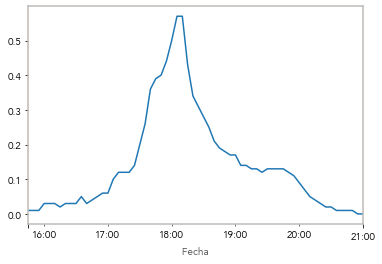

In [9]:
df_st[' Lluvia'].plot()

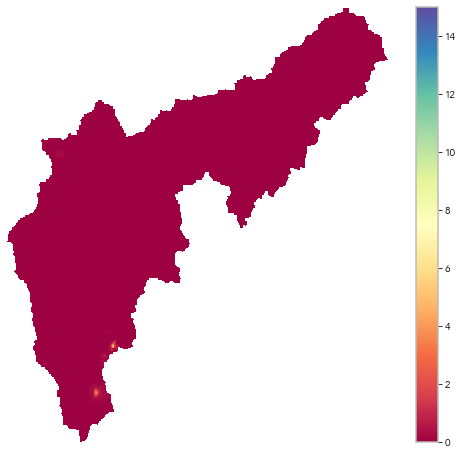

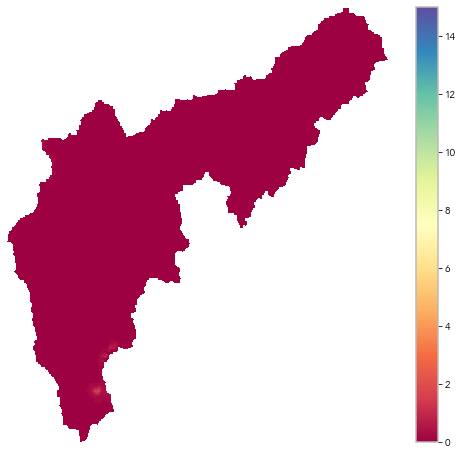

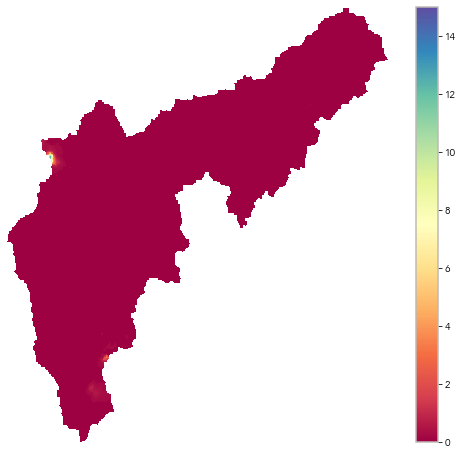

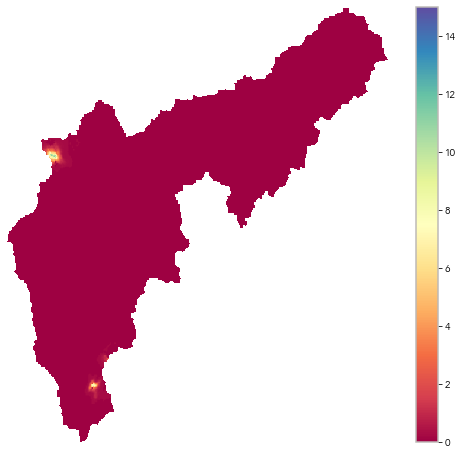

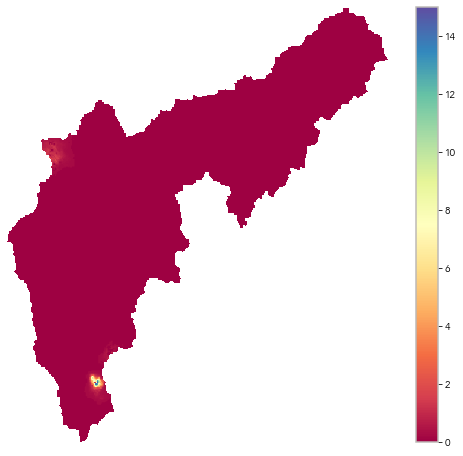

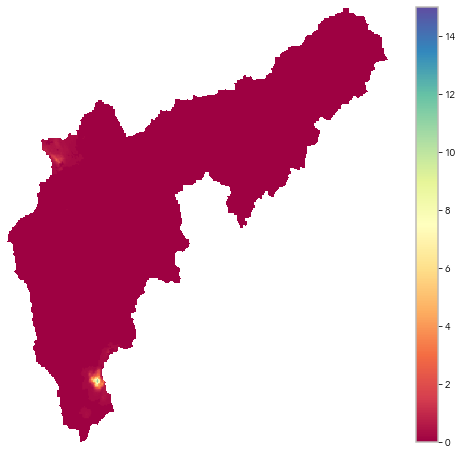

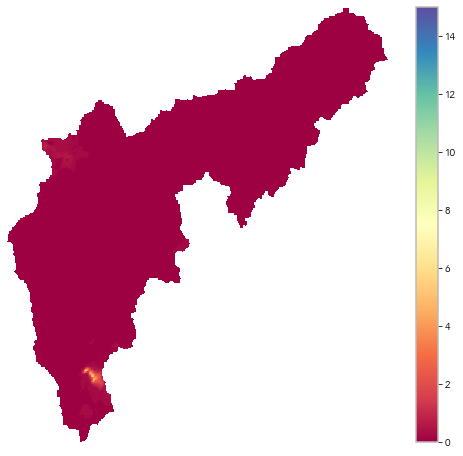

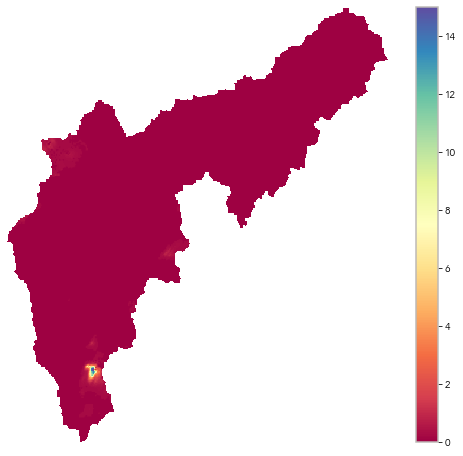

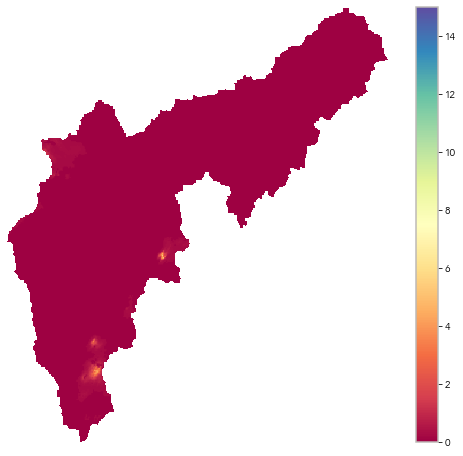

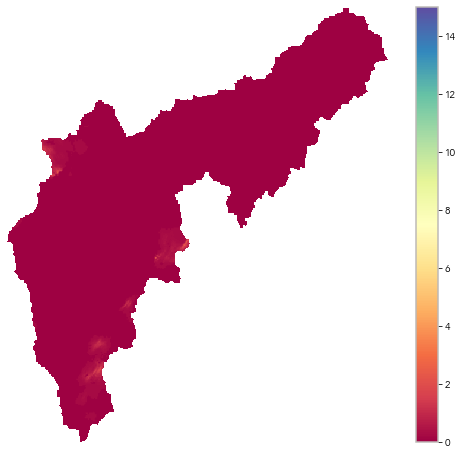

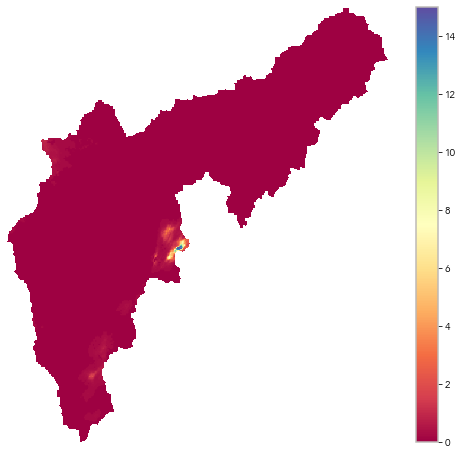

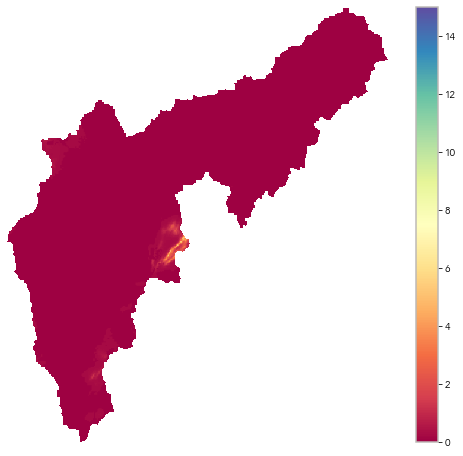

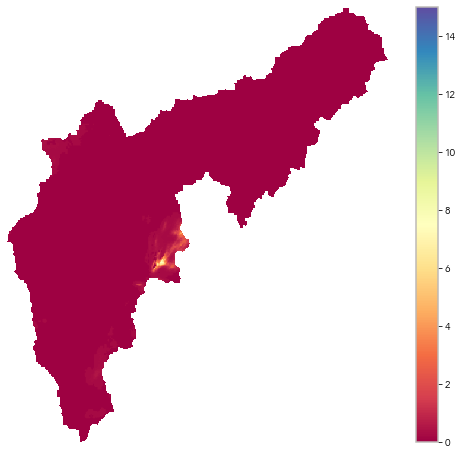

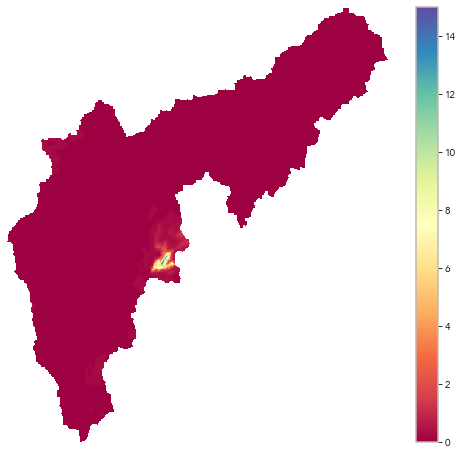

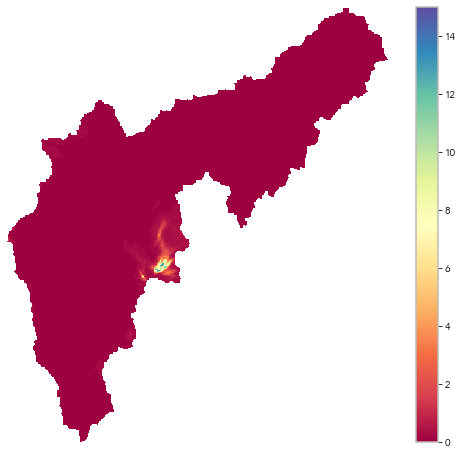

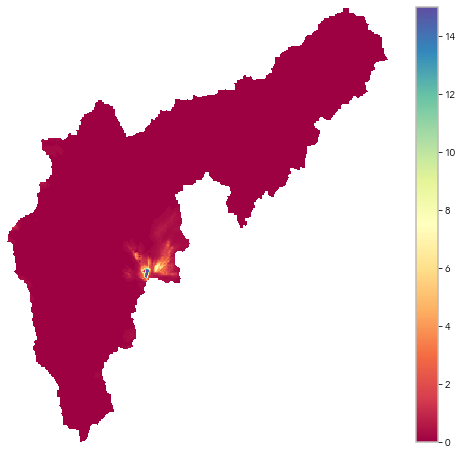

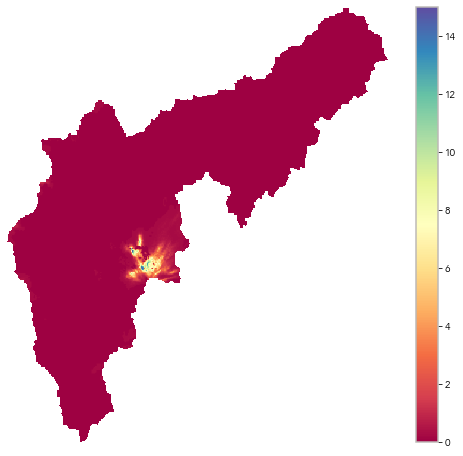

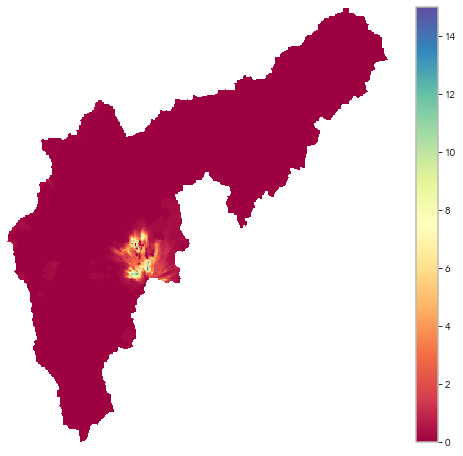

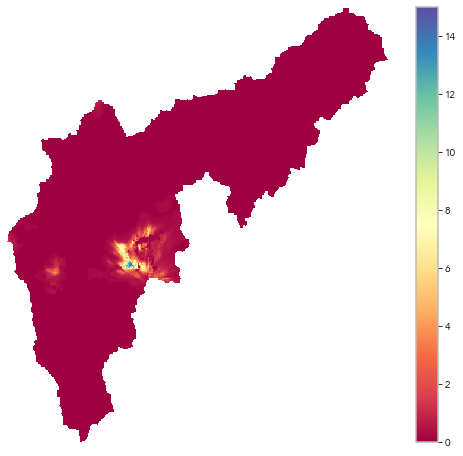

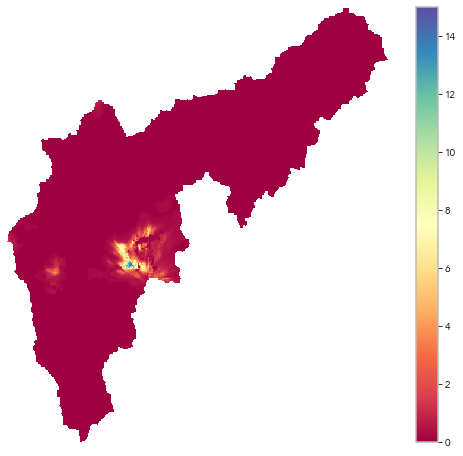

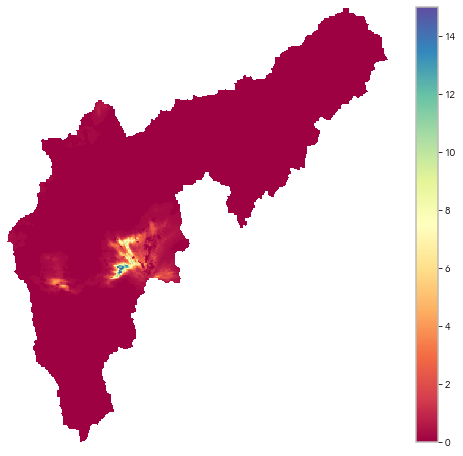

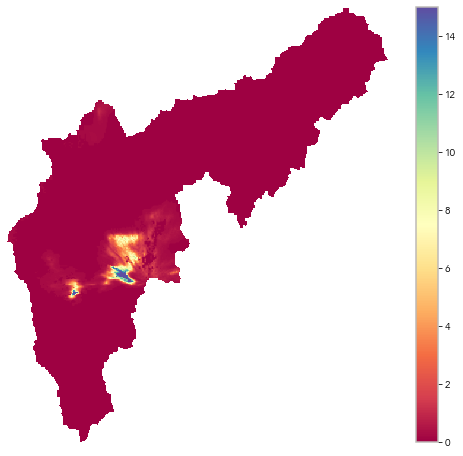

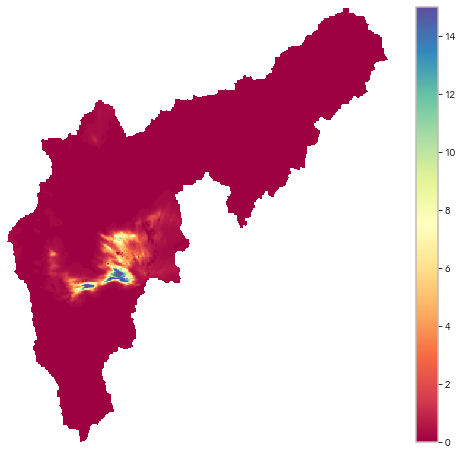

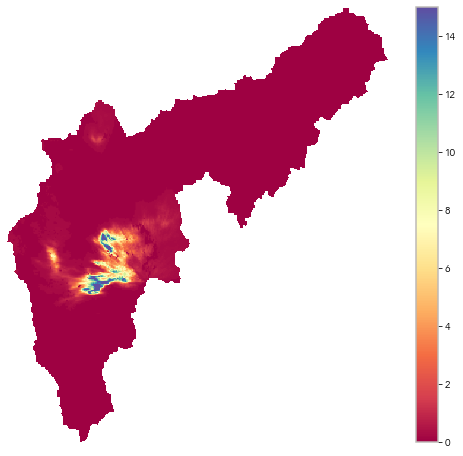

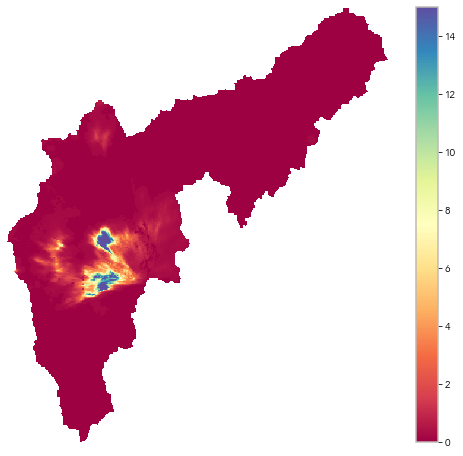

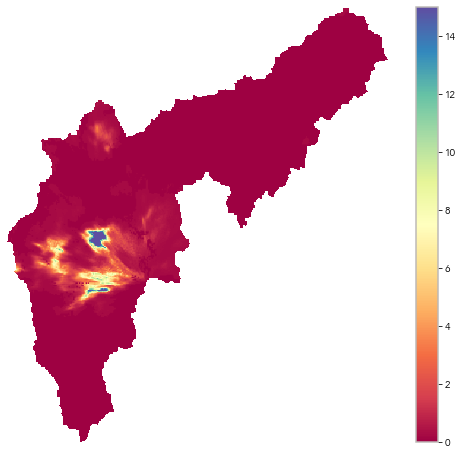

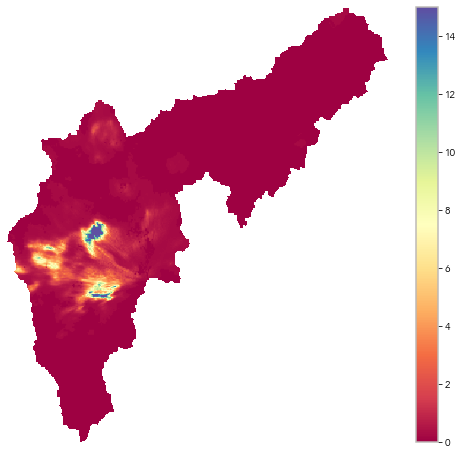

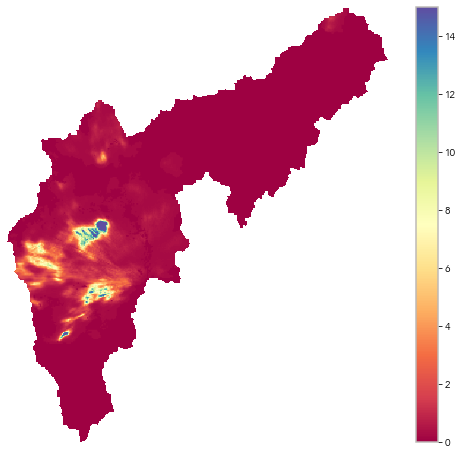

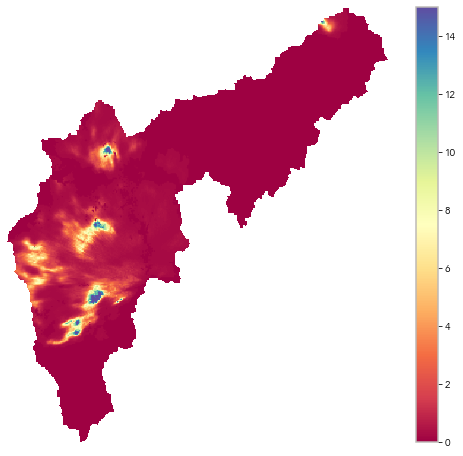

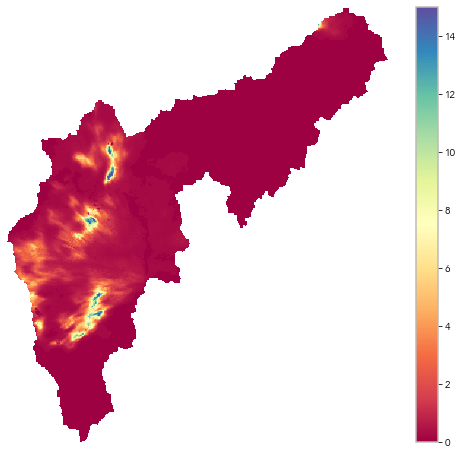

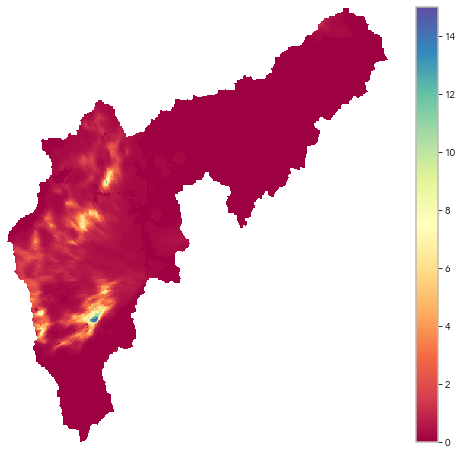

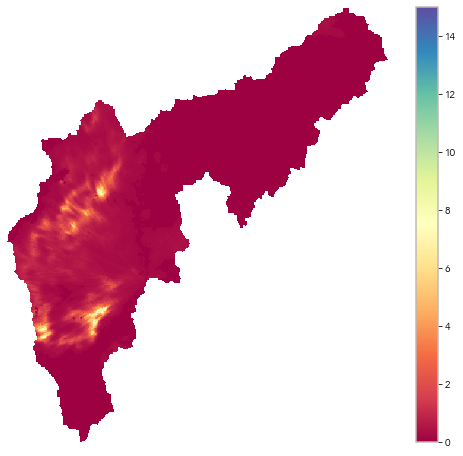

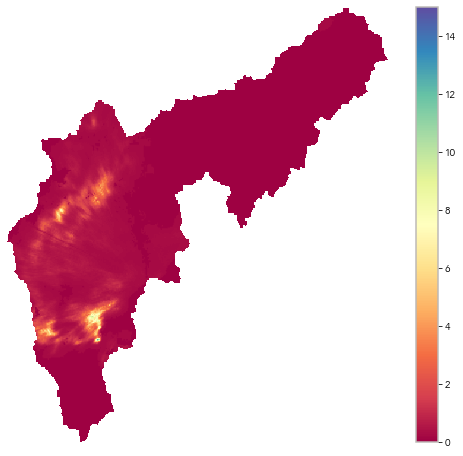

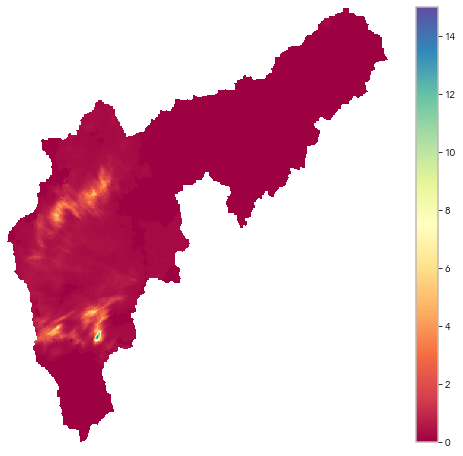

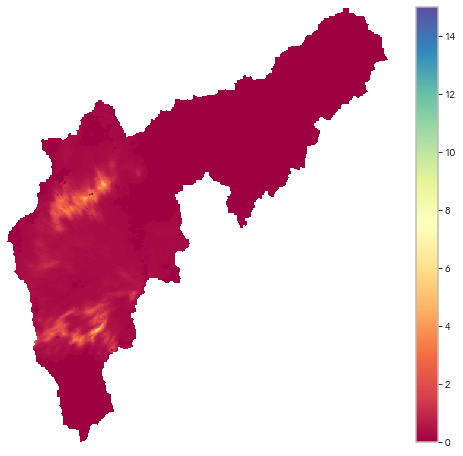

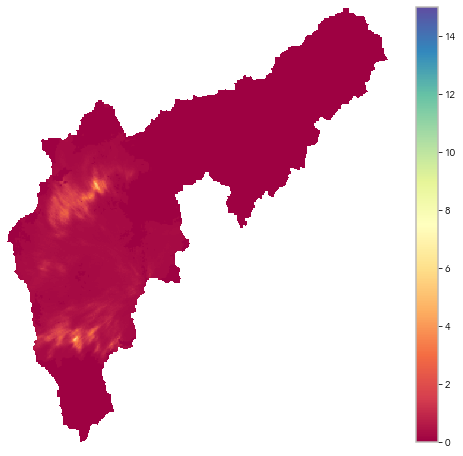

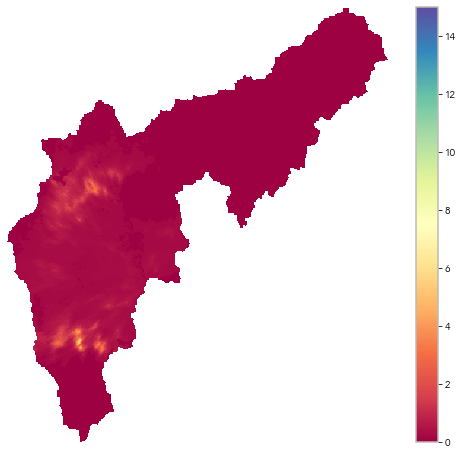

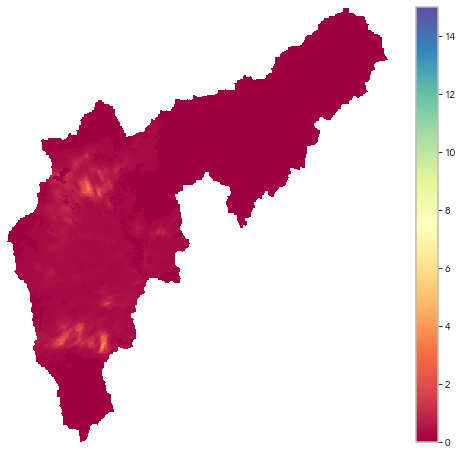

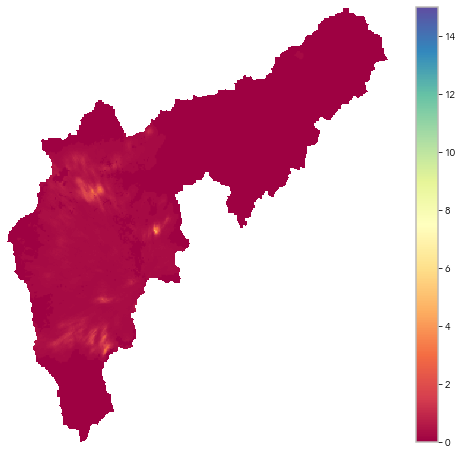

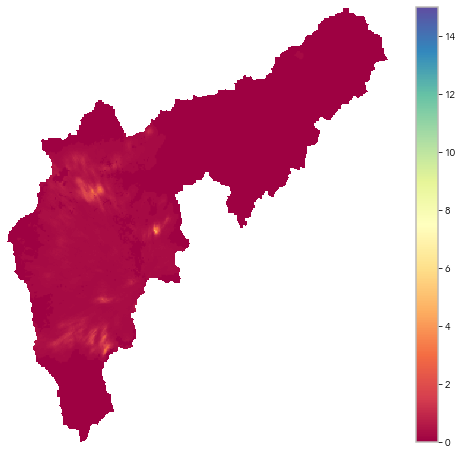

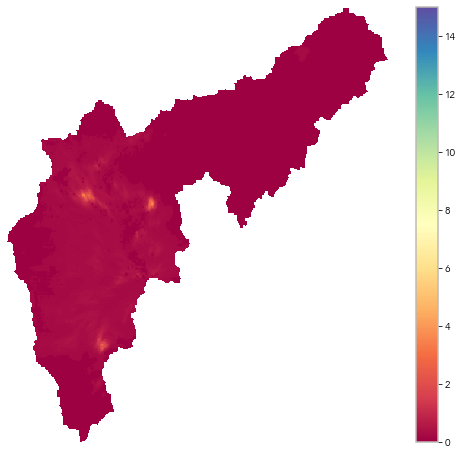

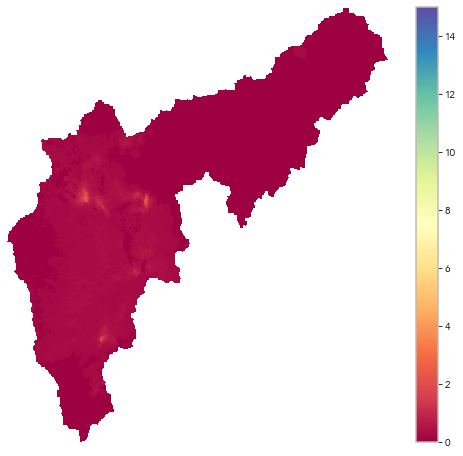

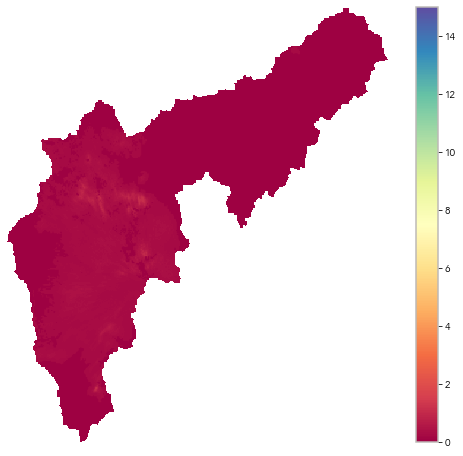

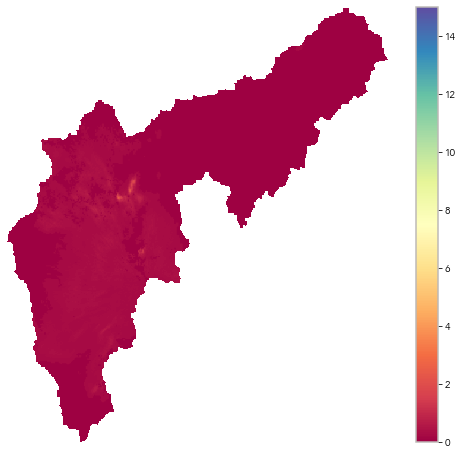

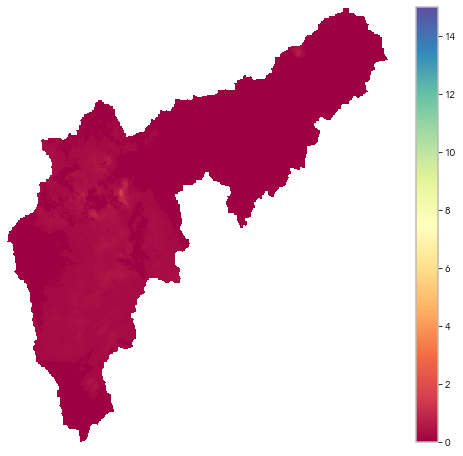

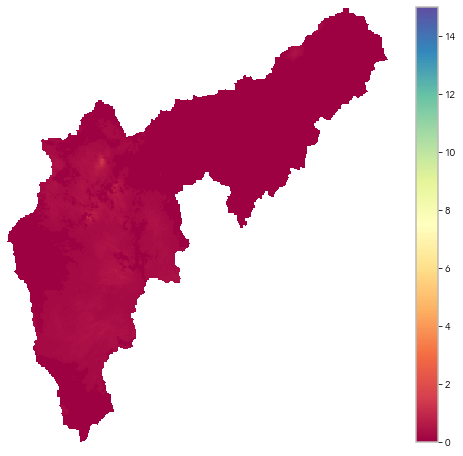

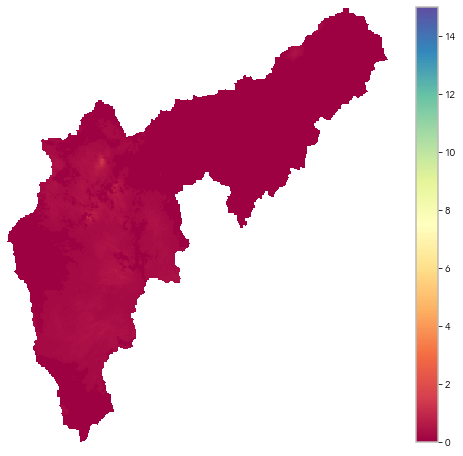

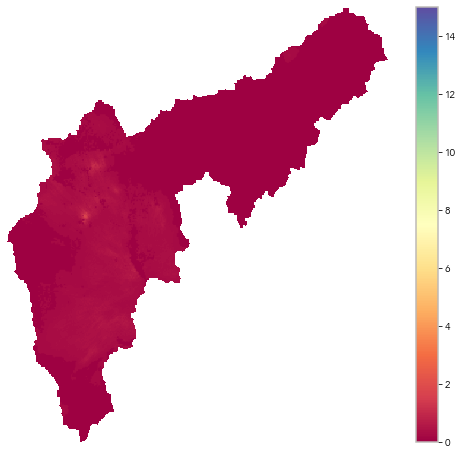

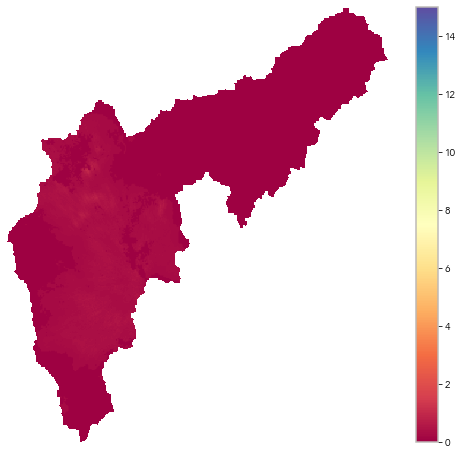

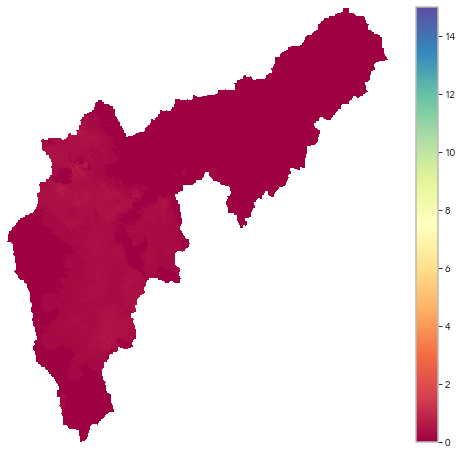

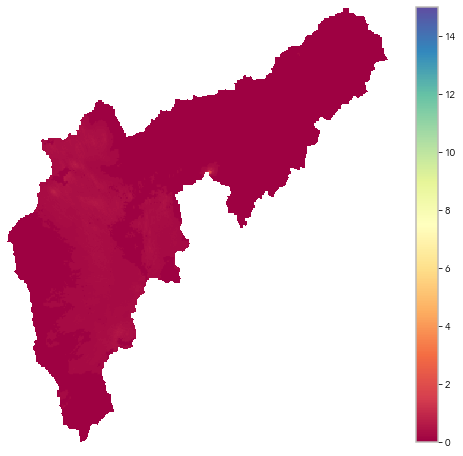

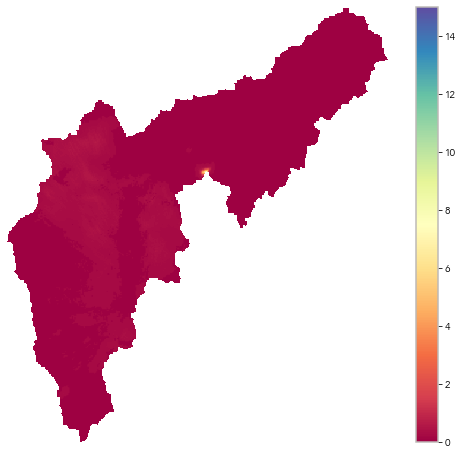

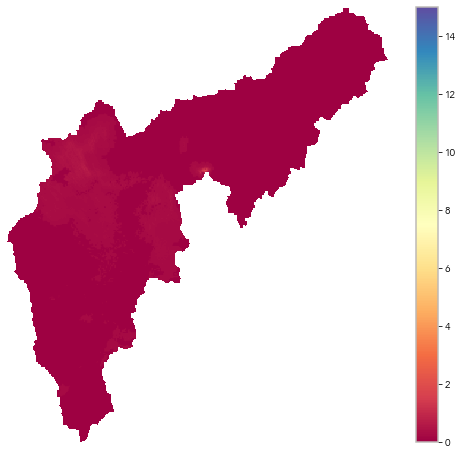

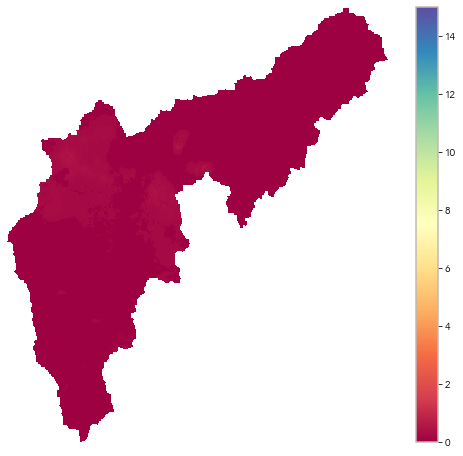

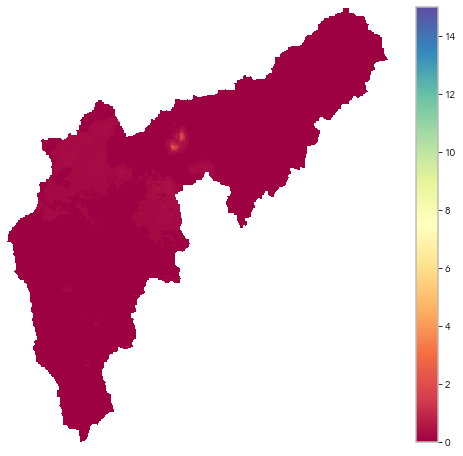

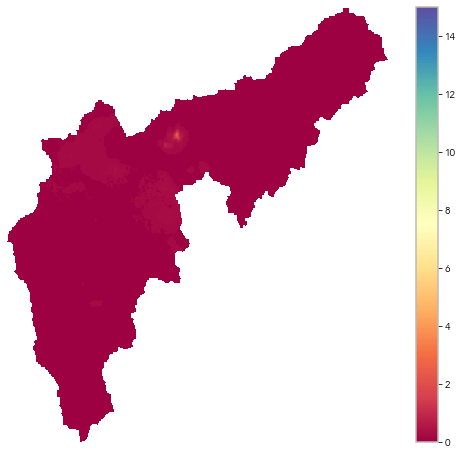

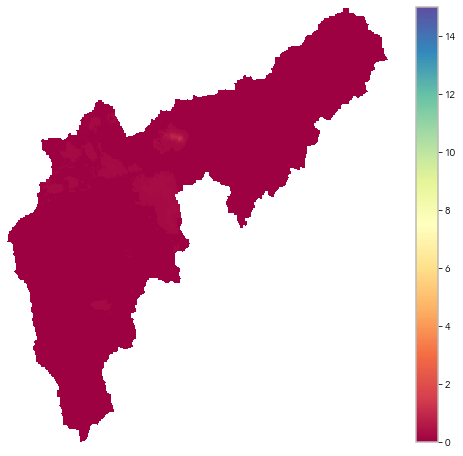

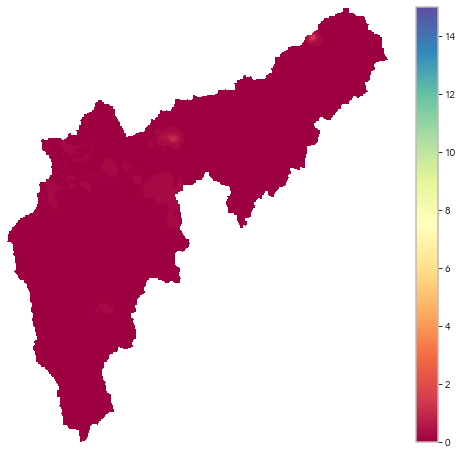

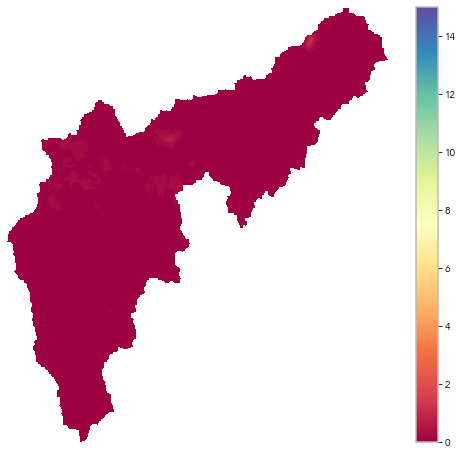

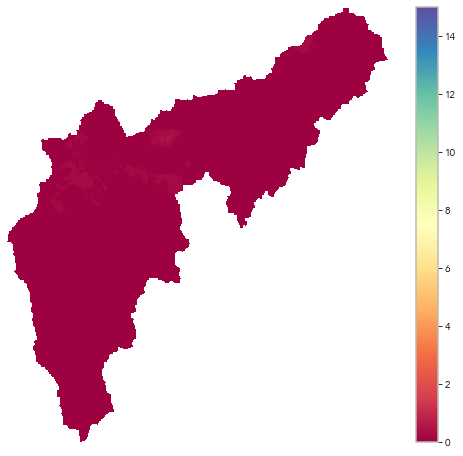

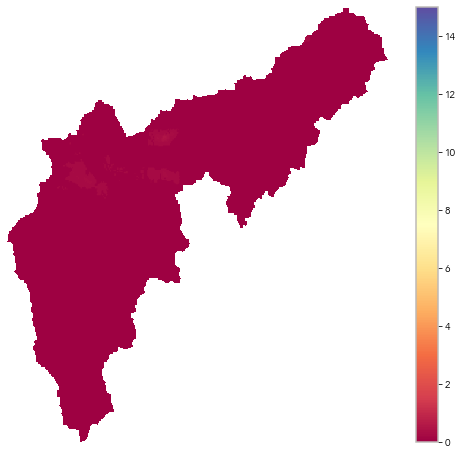

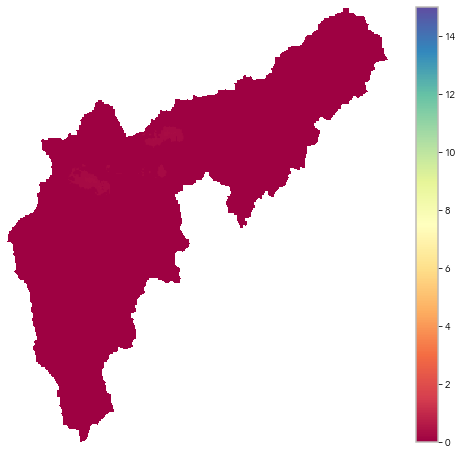

In [11]:
#REVISAR BARRIDOS DEL BINARIO.
records = df_st[' Record'].values[df_st[' Record'].values!=1]
for record in records[:]:
    m = wmf.models.read_int_basin('%s.bin'%path_res,record,cu.ncells)[0]/1000.
    cu.Plot_basinClean(m,show_cbar=True,vmin=0,vmax=15)

### Probar fcns qsim


- ensayar cu.run_shia() como la usa SHop.get_qsim()
- ensayar cu.run_shia() guardando  bin_humedad, abrir y revisar los datos.
- ensayar cu.set_storage()

In [14]:
cuenca= '../files_temp/E260_90m_py3_v111.nc'
cu = wmf.SimuBasin(rute= cuenca)
cal = [1.0 , 5.9 , 5.7 , 0.0 , 1.0 , 1.0 , 10.8 , 1.0 , 1.0 , 1.0, 1]
rain = path_res+'.bin'
npasos = df_st.index.size
path_sto = '../files_temp/binsto_prueba'

In [ ]:
res = cu.run_shia(cal,rain,npasos-1,kinematicN=12)#,ruta_storage=path_sto)

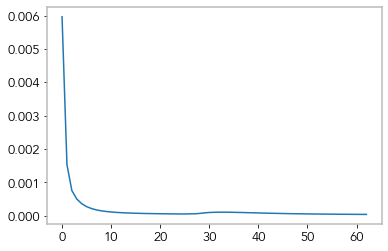

In [37]:
pl.plot(res[0]['Qsim'][0])

- revisar binsto

In [ ]:
f=open(CIpath.split('.')[0]+'.StOhdr')
filelines=f.readlines()
f.close()
IDs=np.array([int(i.split(',')[0]) for i in filelines[5:]])
fechas=np.array([i.split(',')[-1].split(' ')[1] for i in filelines[5:]])
#ultima pos
v,r = wmf.models.read_float_basin_ncol(CIpath.split('.')[0]+'.StObin',IDs[-1], cu.ncells, 5)
CIvar = v

In [ ]:
cu.Plot_basinClean(v[2],show_cbar=True)